In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, DateType, StringType

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, HashingTF
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit


from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gc

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# set data path and read in
data_path = "mini_sparkify_event_data.json"
mini_data = spark.read.json(data_path)

In [4]:
# display the table content
mini_data.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [5]:
# count rows in this dataset
mini_data.count()

286500

In [6]:
# Print the schema in a tree format
mini_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# register the mini data as a SQL temporary view
mini_data.createOrReplaceTempView("df_mini")

In [8]:
# count distinct user_ids
spark.sql("select count(distinct(userId)) from df_mini").show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   226|
+----------------------+



In [9]:
# print out null sums in each column 
[(c, spark.sql("select * from df_mini where {} is Null".format(c)).count()) for c in mini_data.columns]

[('artist', 58392),
 ('auth', 0),
 ('firstName', 8346),
 ('gender', 8346),
 ('itemInSession', 0),
 ('lastName', 8346),
 ('length', 58392),
 ('level', 0),
 ('location', 8346),
 ('method', 0),
 ('page', 0),
 ('registration', 8346),
 ('sessionId', 0),
 ('song', 58392),
 ('status', 0),
 ('ts', 0),
 ('userAgent', 8346),
 ('userId', 0)]

In [10]:
# print out '' sums in each column 
[(c, spark.sql("select * from df_mini where {} = ''".format(c)).count()) for c in mini_data.columns]

[('artist', 0),
 ('auth', 0),
 ('firstName', 0),
 ('gender', 0),
 ('itemInSession', 0),
 ('lastName', 0),
 ('length', 0),
 ('level', 0),
 ('location', 0),
 ('method', 0),
 ('page', 0),
 ('registration', 0),
 ('sessionId', 0),
 ('song', 0),
 ('status', 0),
 ('ts', 0),
 ('userAgent', 0),
 ('userId', 8346)]

In [11]:
# take a look which pages are user in if 
spark.sql("select distinct page from df_mini where artist is not Null").show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



In [12]:
# take a look which pages are user in if 
spark.sql("select song from df_mini where userId = ''").show(2)

+----+
|song|
+----+
|null|
|null|
+----+
only showing top 2 rows



In [13]:
# Filter out userId is null records
mini_data_non0 = mini_data.filter(mini_data.userId != '')

In [14]:
mini_data_non0.count()

278154

In [15]:
mini_data_non0.createOrReplaceTempView("df_mini_non0")

In [16]:
# print out null sums in each column 
[(c, spark.sql("select * from df_mini_non0 where {} is Null".format(c)).count()) for c in mini_data_non0.columns]

[('artist', 50046),
 ('auth', 0),
 ('firstName', 0),
 ('gender', 0),
 ('itemInSession', 0),
 ('lastName', 0),
 ('length', 50046),
 ('level', 0),
 ('location', 0),
 ('method', 0),
 ('page', 0),
 ('registration', 0),
 ('sessionId', 0),
 ('song', 50046),
 ('status', 0),
 ('ts', 0),
 ('userAgent', 0),
 ('userId', 0)]

In [17]:
# add if categorical / continous
def plot_vara_cnt(vara):
    """ Show variable's unique count, if unique values less than 20 plot each value's the distribution.
    INPUT:
    vara: -- (string), variable need to be counted.
    OUTPUT:
    plot corresponding counts
    """
    
    ttl_uniq_cnt = mini_data_non0.select([vara]).dropDuplicates().count()
    mini_data_non0_pd = mini_data_non0.toPandas()
    
    if ttl_uniq_cnt >20:
        print("In this dataset, there are total {} unique {}".format(ttl_uniq_cnt, vara))
        
        
    elif vara in ['gender','firstName','lastnAME','location']:
        mini_data_non0_pd_uni = mini_data_non0_pd.drop_duplicates(['userId','gender'])
        mini_data_non0_pd_uni.groupby([vara])['userId'].count().plot(kind = 'bar')
        plt.show()
        
    else:
        mini_data_non0_pd.groupby([vara])['userId'].count().plot(kind = 'bar')
        plt.show()

In [18]:
plot_vara_cnt('userId')

In this dataset, there are total 225 unique userId


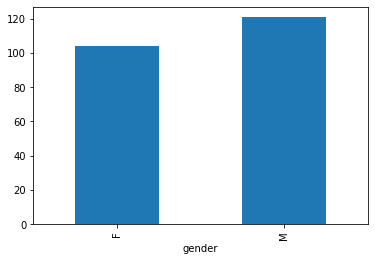

In [19]:
plot_vara_cnt('gender')

In [20]:
plot_vara_cnt('artist')

In this dataset, there are total 17656 unique artist


In [21]:
plot_vara_cnt('itemInSession')

In this dataset, there are total 1311 unique itemInSession


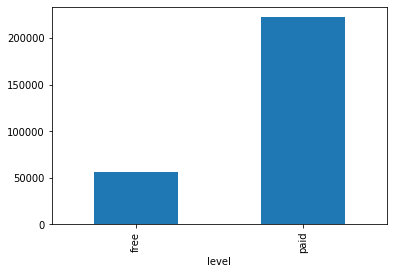

In [22]:
plot_vara_cnt('level')

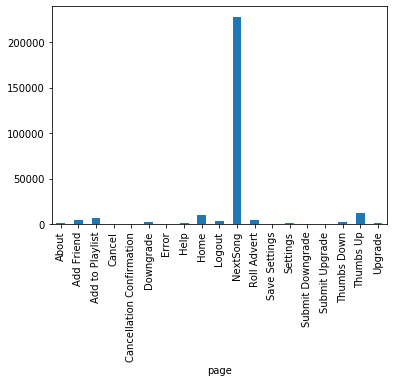

In [23]:
plot_vara_cnt('page')

In [24]:
plot_vara_cnt('registration')

In this dataset, there are total 225 unique registration


In [25]:
plot_vara_cnt('song')

In this dataset, there are total 58481 unique song


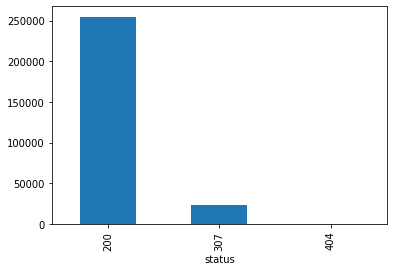

In [26]:
plot_vara_cnt('status')

In [27]:
plot_vara_cnt('userAgent')

In this dataset, there are total 56 unique userAgent


In [28]:
gc.collect()

0

# Feature Engineering
## Define Churn
For a music service company, we could define churn as cancel service and even more downgrade service could be counted. I will create a column Churn by using either the Cancellation Confirmation events alone or with Downgrade events together. Will decide after exploring the event counts.

In [29]:
# Define Churn
# To look how many unique users submit cancellation
mini_data_non0.select(['userId']).where(mini_data_non0.page.isin(['Cancellation Confirmation'])).dropDuplicates().count()

52

In [30]:
# Look how many unique users submit cancellation or Downgrade
mini_data_non0.select(['userId']).where(mini_data_non0.page.isin(['Cancellation Confirmation','Downgrade'])).dropDuplicates().count()

171

In [31]:
# Total users
mini_data_non0.select(['userId']).dropDuplicates().count()

225

## Findings

1. There are total 225 unique users in this dataset.
2. Out of these 225 unique users, 52 submitted cancellations and 171 submitted either cancellations or downgrades.


Decide to use the Cancellation Confirmation events as churn label since the proportion of Downgrade users is too large.

In [32]:
# Create new column to label cancellation or not
# define churn function
cancellation_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
# apply churn function
mini_data_non0 = mini_data_non0.withColumn("churn", cancellation_event("page"))
# fill churn user na as 0s
mini_data_non0 = mini_data_non0.na.fill({'churn': 0})

In [33]:
# get some time related cols from ts
ts_to_hour = udf(lambda x: datetime.fromtimestamp(x / 1000.0).hour)
mini_data_non0 = mini_data_non0.withColumn("hour",ts_to_hour("ts"))
ts_to_day = udf(lambda x: datetime.fromtimestamp(x / 1000.0).day)
mini_data_non0 = mini_data_non0.withColumn("day",ts_to_day("ts"))
mini_data_non0 = mini_data_non0.withColumn("date",from_unixtime(mini_data_non0.ts/1000).cast(DateType()))

In [34]:
# set a temp sql view
mini_data_non0.createOrReplaceTempView("df_mini_non0")

# churn users' churn date distirbution
churn_date = spark.sql("select distinct date, userId \
               from df_mini_non0 where churn = 1 \
               order by date")

churn_date.show(5)

+----------+------+
|      date|userId|
+----------+------+
|2018-10-02|100011|
|2018-10-02|100001|
|2018-10-05|100006|
|2018-10-05|300007|
|2018-10-05|100024|
+----------+------+
only showing top 5 rows



In [35]:
churn_date.count()

52

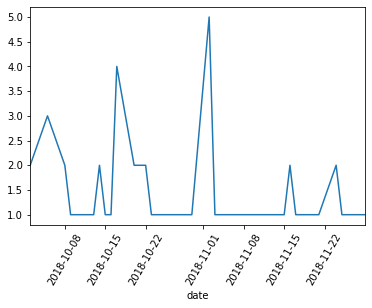

In [36]:
# Plot churn date distirbution
churn_date_pd = churn_date.toPandas()
churn_date_pd.groupby('date')['userId'].count().plot()
plt.xticks(rotation = 60)
plt.show()

In [37]:
spark.sql("select after_1101, count(*) from \
          (select userId, date, \
           case when date >= '2018-11-01' then 'Y' else 'N' end as after_1101\
           from df_mini_non0 \
           where churn = 1) as a \
           group by after_1101").show()

+----------+--------+
|after_1101|count(1)|
+----------+--------+
|         Y|      22|
|         N|      30|
+----------+--------+



## Thoughts: 

In order to take actions before user churn, we need set-up an observation period and to predict user churn scenario in the upcoming target period. In real business world, month is common period for track the performance metric. Thus, in this project I'll use user monthly activities to predict next month churn.

I will select 2018-11-01 as the benchmark date, 2018-10-01 to 2018-10-31 as the observational period and customers active at 2018-10-31 as base customer counts. Customers who churned between 2018-11-01 and 2018-11-30 as target churned customers. All customers who churned before 2018-11-01 will be removed from the analysis. In other words, only keep customers who were active at 2018-10-31.

Unique customers:

- Baseline: (214 - (52-22)) = 184.
- Churned in the folowing month: 22.
- Monthly Churn Rate: 22/184 = 12%


1. Get obervational period data

In [38]:
mini_data_non0.createOrReplaceTempView("df_mini_non0")

mini_data_obv = spark.sql("select * from df_mini_non0 \
                          where date >= '2018-10-01' and date < '2018-11-01'")

2. Remove users churned between 2018-10-01 and 2018-11-01

In [39]:
# get unique churn users
churn_user_obv = mini_data_obv.select(['userId']).where(mini_data_obv.churn == 1).dropDuplicates()
# assign new churn user label to churn users
churn_user_obv = churn_user_obv.withColumn("churn_user_obv", lit(1))
# join churn user back to original table and got an label
mini_data_obv = mini_data_obv.join(churn_user_obv, "userId", how = 'outer')
# remove users records who churn between 2018-10-01 and 2018-11-01
mini_data_obv = mini_data_obv.where(col('churn_user_obv').isNull())

3.Get unique userIds who churned during target period 2018-11-01 and 2018-12-01, then join back with the observational period.

In [40]:
# Churn period data
mini_data_target = spark.sql("select * from df_mini_non0 \
                          where date >= '2018-11-01' and date < '2018-12-01'")

# unique users churned during the target period
churn_user_target = mini_data_target.select(['userId']).where(mini_data_target.churn == 1).dropDuplicates()

# assign new churn user label to churn users
churn_user_target = churn_user_target.withColumn("churn_user_target", lit(1))

# join churn user back to observal table and got an label
mini_data_obv = mini_data_obv.join(churn_user_target, "userId", how = 'outer')

# fill na with 0s in the observational dataset
mini_data_obv = mini_data_obv.fillna(0, subset = ['churn_user_target'])

# Drop some columns
mini_data_obv = mini_data_obv.drop('churn').drop('churn_user_obv')

In [41]:
# set temp sql view
mini_data_obv.createOrReplaceTempView("df_mini_non0_obv")

# churn/not churn counts
spark.sql("select churn_user_target, count(*) as cnt from df_mini_non0_obv\
           group by churn_user_target order by churn_user_target").show()

+-----------------+------+
|churn_user_target|   cnt|
+-----------------+------+
|                0|106629|
|                1| 19624|
+-----------------+------+



In [42]:
# unique churn/nonchurn unique user counts in observational period
spark.sql("select churn_user_target, count(*) as cnt from \
          (select distinct userId,  churn_user_target from df_mini_non0_obv)\
          group by churn_user_target order by churn_user_target").show()

+-----------------+---+
|churn_user_target|cnt|
+-----------------+---+
|                0|161|
|                1| 22|
+-----------------+---+



## Data Transformation and Explotary
Transform raw log data into user - feature format dataframe. For example, for certain time period keep distinct values for each customer -- gender, aggregate (sum or average) -- total song played, pages visited etc, paid/free status change etc.

Then perform some data exploratary between churn/stay group users.

4. Transform dataframe into user - feature format. Total would be 184 rows and many columns.

In [43]:
# gender
df_gender = spark.sql("select distinct userId, gender, churn_user_target from df_mini_non0_obv")
df_gender.count()

183

In [44]:
# Total songs played during the month
df_song = spark.sql("select userId, count(song) as ttl_song\
                     from df_mini_non0_obv \
                     where song is not Null \
                     group by userId")

df_song.describe('ttl_song').show()

+-------+-----------------+
|summary|         ttl_song|
+-------+-----------------+
|  count|              182|
|   mean|565.4395604395604|
| stddev|636.7841288173081|
|    min|                1|
|    max|             4971|
+-------+-----------------+



In [45]:
# userAgent
df_useAgen = spark.sql("select distinct userId, userAgent, churn_user_target from df_mini_non0_obv")
remove_qot = udf(lambda x: x.replace(u'"',''))
substr_agent = udf(lambda x: x[13:21], StringType())
df_useAgen = df_useAgen.withColumn("opr_system", substr_agent(remove_qot("userAgent")))
df_useAgen.select(['opr_system']).dropDuplicates().show()

+----------+
|opr_system|
+----------+
|  iPad; CP|
|  Windows |
|  compatib|
|  Macintos|
|  iPhone; |
|  X11; Ubu|
|  X11; Lin|
+----------+



In [46]:
# location
df_location = spark.sql("select distinct userId, location, churn_user_target from df_mini_non0_obv")
# extract State -- 37
substr_state = udf(lambda x: x[-2:], StringType())
df_location = df_location.withColumn("state", substr_state("location"))
df_location.count()

183

In [47]:
# Pages
# Use pivot table to transform them into user-page format and value as how many times user visited.
# reshap page count -- userId as row and page as column, count as value
df_page = mini_data_obv.groupby('userId').pivot('page').count()
# fillna as 0s
df_page = df_page.fillna(0)
df_page.show(2)

+------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|200002|    2|         4|              6|        3|    0|   1|  14|     3|     267|          7|            0|       3|               0|             1|          6|       15|      2|
|100010|    0|         3|              2|        0|    0|   1|   6|     2|     120|         22|            0|       0|               0|             0|          1|        6|      1|
+------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+

In [ ]:
df_page.count()

In [48]:
df_page.printSchema()

root
 |-- userId: string (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)



In [49]:
# avg song length
df_song_length = spark.sql("select userId, round(avg(length)) as avg_song_length\
                        from df_mini_non0_obv \
                        where song is not Null \
                        group by userId")

df_song_length.describe('avg_song_length').show()

+-------+------------------+
|summary|   avg_song_length|
+-------+------------------+
|  count|               182|
|   mean|248.86263736263737|
| stddev| 7.287909435847549|
|    min|             222.0|
|    max|             280.0|
+-------+------------------+



## Thoughts:

For "level", users might be paid/free level for the month, they could change from paid to free, free to paid in this month, maybe many times. So I created variables to track how many times each user from paid to free, from free to paid, and indicator of they staying paid/free for the whole month.

In [50]:
# detect level change
# reference: https://fle.github.io/detect-value-changes-between-successive-lines-with-postgresql.html

# mark level, prev_level, next_level and level change label and always paid or always free label

df_level = spark.sql("select userId, ttl_paid2free, ttl_free2paid, \
                      case when ttl_lvl_free == 0 then 1 else 0 end as always_paid, \
                      case when ttl_lvl_paid == 0 then 1 else 0 end as always_free \
                      from  \
                      (select userId, sum(paid2free) as ttl_paid2free, sum(free2paid) as ttl_free2paid, \
                      sum(level_paid) as ttl_lvl_paid, sum(level_free) as ttl_lvl_free \
                      from \
                      (select userId, date, level, prev_level, next_level, page, hour, \
                       case when (prev_level == 'paid' and level == 'free') then 1 else 0 end as paid2free, \
                       case when (prev_level == 'free' and level == 'paid') then 1 else 0 end as free2paid, \
                       case when (level == 'paid') then 1 else 0 end as level_paid, \
                       case when (level == 'free') then 1 else 0 end as level_free \
                       from \
                       (select userId, date, level, page, hour, \
                       lag(level) OVER (ORDER BY userId, date) as prev_level, \
                       lead(level) OVER (ORDER BY userId,date) as next_level \
                       from df_mini_non0_obv) as a) as b \
                       group by userId) as c")

In [52]:
df_level.show(5)

+------+-------------+-------------+-----------+-----------+
|userId|ttl_paid2free|ttl_free2paid|always_paid|always_free|
+------+-------------+-------------+-----------+-----------+
|    10|            0|            0|          1|          0|
|   100|            0|            0|          1|          0|
|100002|            0|            0|          1|          0|
|100004|            3|            2|          0|          0|
|100007|            0|            1|          1|          0|
+------+-------------+-------------+-----------+-----------+
only showing top 5 rows



In [53]:
# method 
df_method = spark.sql("select distinct userId, method, churn_user_target from df_mini_non0_obv sort by userId")
df_method.count()

364

In [54]:
spark.sql("select distinct method from df_mini_non0_obv").show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [55]:
# registration -- drop since each user has an distinct regi number
df_regi = spark.sql("select distinct userId, registration, churn_user_target from df_mini_non0_obv sort by userId")
df_regi.count()

183

In [56]:
# sessionId -- drop since too much level
df_session = spark.sql("select distinct userId, sessionId, churn_user_target from df_mini_non0_obv sort by userId")
df_session.count()

1601

In [57]:
spark.sql("select distinct status from df_mini_non0_obv").show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [58]:
# select distinct gender, state, opr system, total songs, pages,level-status and join them together

df_fe = df_gender.join(df_location.select(['userId','state']), "userId")\
                 .join(df_useAgen.select(['userId','opr_system']), "userId")\
                 .join(df_song, "userId")\
                 .join(df_page, "userId")\
                 .join(df_song_length, "userId")\
                 .join(df_level, "userId")

In [59]:
df_fe.show(2)

+------+------+-----------------+-----+----------+--------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+---------------+-------------+-------------+-----------+-----------+
|userId|gender|churn_user_target|state|opr_system|ttl_song|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|avg_song_length|ttl_paid2free|ttl_free2paid|always_paid|always_free|
+------+------+-----------------+-----+----------+--------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+---------------+-------------+-------------+-----------+-----------+
|100010|     F|                0|   CT|  iPhone; |     120|    0|         3|              2|        

In [60]:
# replace space with '_' in column names 
# https://stackoverflow.com/questions/41655158/dynamically-rename-multiple-columns-in-pyspark-dataframe
col_replace = {c:c.replace(' ', '_') for c in df_fe.columns if ' ' in c}
df_fe = df_fe.select([col(c).alias(col_replace.get(c,c)) for c in df_fe.columns])

# create and temp view
df_fe.createOrReplaceTempView("mini_fe")

In [61]:
# Explore difference between churn/stay user
# https://stackoverflow.com/questions/1823599/calculating-percentage-within-a-group

# add if categorical / continous
def cunt_bychurn_vara(vara):
    """ Show variable's unique count, and proportion by vara and churn/stay.
    INPUT:
    vara: -- (string), variable need to be counted.
    OUTPUT:
    df -- (dataframe), vara and corresponding proportion / avg value
    """
    
    # check if categorical variable, if so then display proportions
    if vara in [c[0] for c in df_fe.dtypes if c[1] == 'string']:
        df = spark.sql("select {}, churn_user_target, count(*) as {}_cnt, \
                   round(count(*)/CAST( SUM(count(*)) over (partition by churn_user_target) as float), 2) as {}_pctg\
                   from mini_fe group by {}, churn_user_target \
                   order by  churn_user_target, {}".format(vara,vara,vara,vara,vara))
    # if is date then skip    
    elif vara in [c[0] for c in df_fe.dtypes if c[1] == 'date']:
        print('Input variable is date.')
        
    # if continous type like int, big int, float then display average between two groups
    else: 
        df = spark.sql("select churn_user_target, round(avg({}),2) as avg_{}_mthly\
                   from mini_fe group by churn_user_target".format(vara, vara))
        
    return df

In [62]:
cunt_bychurn_vara('ttl_paid2free').show()

+-----------------+-----------------------+
|churn_user_target|avg_ttl_paid2free_mthly|
+-----------------+-----------------------+
|                1|                   0.45|
|                0|                   0.66|
+-----------------+-----------------------+



In [63]:
cunt_bychurn_vara('always_free').show()

+-----------------+---------------------+
|churn_user_target|avg_always_free_mthly|
+-----------------+---------------------+
|                1|                 0.23|
|                0|                 0.36|
+-----------------+---------------------+



In [64]:
cunt_bychurn_vara('ttl_free2paid').show()

+-----------------+-----------------------+
|churn_user_target|avg_ttl_free2paid_mthly|
+-----------------+-----------------------+
|                1|                   0.77|
|                0|                    0.6|
+-----------------+-----------------------+



In [65]:
cunt_bychurn_vara('always_paid').show()

+-----------------+---------------------+
|churn_user_target|avg_always_paid_mthly|
+-----------------+---------------------+
|                1|                 0.09|
|                0|                 0.18|
+-----------------+---------------------+



In [67]:
cunt_bychurn_vara('gender').show()

+------+-----------------+----------+-----------+
|gender|churn_user_target|gender_cnt|gender_pctg|
+------+-----------------+----------+-----------+
|     F|                0|        77|       0.48|
|     M|                0|        83|       0.52|
|     F|                1|        11|        0.5|
|     M|                1|        11|        0.5|
+------+-----------------+----------+-----------+



In [66]:
cunt_bychurn_vara("Thumbs_Down").show()

+-----------------+---------------------+
|churn_user_target|avg_Thumbs_Down_mthly|
+-----------------+---------------------+
|                1|                10.82|
|                0|                 5.98|
+-----------------+---------------------+



In [68]:
cunt_bychurn_vara("ttl_song").show()

+-----------------+------------------+
|churn_user_target|avg_ttl_song_mthly|
+-----------------+------------------+
|                1|            722.41|
|                0|            543.86|
+-----------------+------------------+



In [69]:
gc.collect()

5539

5. Plot variable distribution between churn/stay groups

In [70]:
# Explore difference between churn/stay user
# https://stackoverflow.com/questions/1823599/calculating-percentage-within-a-group

# add if categorical / continous
def plot_churn_vara(vara):
    """ Show variable's unique count, and proportion by vara and churn/stay.
    INPUT:
    vara: -- (string), variable need to be counted.
    OUTPUT:
    plot corresponding proportion / avg value by churn/stay
    """
    
    # convert spark df to pandas
    df_fe_pd = df_fe.toPandas()
    
    # check if categorical variable, if so then display proportions
    if vara in [c[0] for c in df_fe.dtypes if c[1] == 'string']:
        df_fe_pd.groupby(['churn_user_target',vara])['userId'].count().plot(kind = 'bar', color = 'g')
        plt.ylabel('{}_count'.format(vara))
        plt.show()    
        
    # if is date then skip    
    elif vara in [c[0] for c in df_fe.dtypes if c[1] == 'date']:
        print('Input variable is date.')
        
    # if continous type like int, big int, float then display average between two groups
    else: 
        df_fe_pd.groupby(['churn_user_target'])[vara].mean().plot(kind = 'bar')
        plt.ylabel('monthly_avg_{}'.format(vara))
        plt.show()

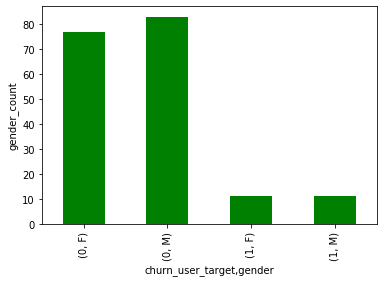

In [71]:
plot_churn_vara('gender')

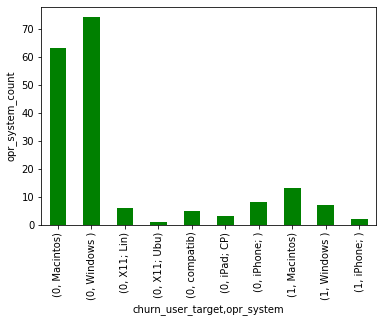

In [72]:
plot_churn_vara('opr_system')

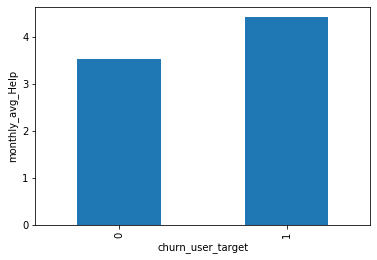

In [73]:
plot_churn_vara('Help')

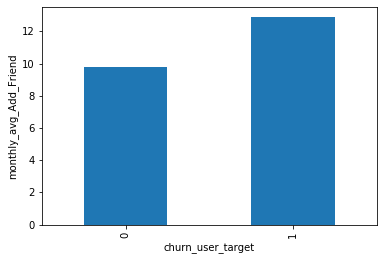

In [74]:
plot_churn_vara('Add_Friend')

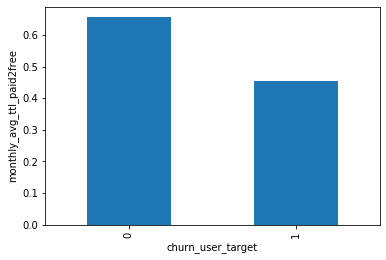

In [75]:
plot_churn_vara('ttl_paid2free')

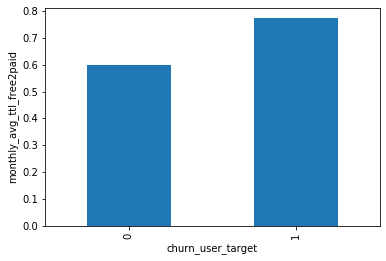

In [76]:
plot_churn_vara('ttl_free2paid')

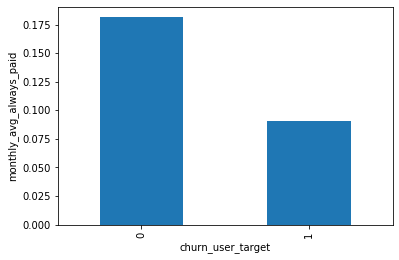

In [77]:
plot_churn_vara('always_paid')

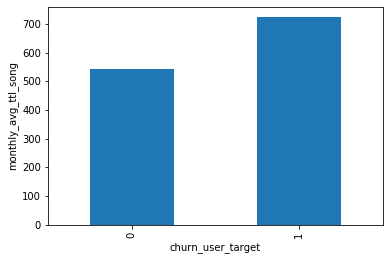

In [78]:
plot_churn_vara('ttl_song')

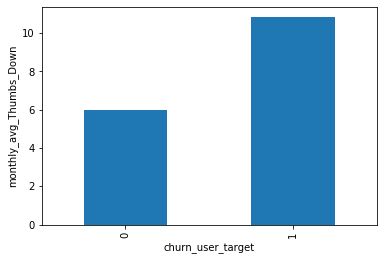

In [79]:
plot_churn_vara('Thumbs_Down')

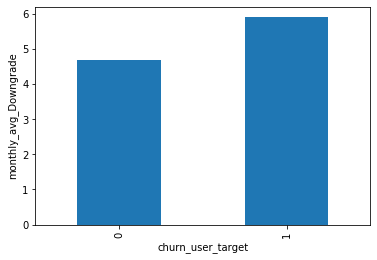

In [80]:
plot_churn_vara('Downgrade')

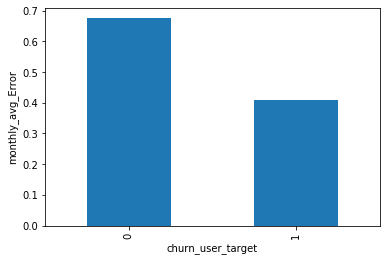

In [81]:
plot_churn_vara('Error')

## Feature Engineering
Now we get cleaned user-feature dataset with each row represents an unique user and each feature shows their demographics or aggregation activities of last month. But before fitting into machine learning model, we need to do final data processing. We need to convert categorical features into dummy values and scale continuous features.

### Categorical Features

First, we need to use StringIndexer to index categorical values. Then we will use OneHotEncoder to convert the indexer into dummy vectors.

### Continuous Features 
Scale the numerical data before fitting into machine learning models. StandardScaler will be applied

In [82]:
df_fe.dtypes

[('userId', 'string'),
 ('gender', 'string'),
 ('churn_user_target', 'int'),
 ('state', 'string'),
 ('opr_system', 'string'),
 ('ttl_song', 'bigint'),
 ('About', 'bigint'),
 ('Add_Friend', 'bigint'),
 ('Add_to_Playlist', 'bigint'),
 ('Downgrade', 'bigint'),
 ('Error', 'bigint'),
 ('Help', 'bigint'),
 ('Home', 'bigint'),
 ('Logout', 'bigint'),
 ('NextSong', 'bigint'),
 ('Roll_Advert', 'bigint'),
 ('Save_Settings', 'bigint'),
 ('Settings', 'bigint'),
 ('Submit_Downgrade', 'bigint'),
 ('Submit_Upgrade', 'bigint'),
 ('Thumbs_Down', 'bigint'),
 ('Thumbs_Up', 'bigint'),
 ('Upgrade', 'bigint'),
 ('avg_song_length', 'double'),
 ('ttl_paid2free', 'bigint'),
 ('ttl_free2paid', 'bigint'),
 ('always_paid', 'int'),
 ('always_free', 'int')]

In [83]:
### Dealing with Categorical Variables
# https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html

# collect categorical variables
cate_cols = [c[0] for c in df_fe.dtypes if (c[1] == 'string' and c[0] not in ['userId','state'])]

# pipeline stages
stages = []

for cat in cate_cols:
    # Indexing on categorical variables
    string_indexer = StringIndexer(inputCol = cat, outputCol = cat + "Index")
    
    # OneHotEncoding on categorical variables to dummy vectors
    dum_encoder = OneHotEncoder(inputCol = string_indexer.getOutputCol(), outputCol = cat + "classVec")
    
    stages += [string_indexer, dum_encoder]

In [84]:
### Dealing with numerical variables
# https://blog.usejournal.com/tutorial-on-pyspark-transformations-and-mlib-7ed289a9e843

# collect continous variable
conti_cols = [c[0] for c in df_fe.dtypes if c[1] in ('int','bigint','double') and c[0] != 'churn_user_target']

# assemble continous variables
conti_assemb = VectorAssembler(inputCols = conti_cols, outputCol = "conti_varas_vec")
cat_scaler = StandardScaler(inputCol = "conti_varas_vec", outputCol = "conti_scaled_feats")
stages += [conti_assemb, cat_scaler]

In [85]:
# conver target variable into label indices
label_strIdx = StringIndexer(inputCol = "churn_user_target", outputCol = "label")
stages += [label_strIdx]

In [86]:
# Assemble vectors together
assembler_varas = [c + "Index" for c in cate_cols] + ["conti_scaled_feats"]
# Apply vectorAssembler
assembler = VectorAssembler(inputCols = assembler_varas, outputCol = "features")
stages += [assembler]

In [88]:
# ML Prediction Model
model = RandomForestClassifier(featuresCol = "features", labelCol = "label", numTrees = 10)# LogisticRegression(featuresCol = "features", labelCol = "label")#
stages += [model]

In [89]:
# Compile pipeline
pipeline = Pipeline().setStages(stages)

In [90]:
# For next part using convenience, Let's create a pipeline function

def ml_pipeline(df, model):
    """Build feature vector processing and ML pipeline for prediction ready.
    INPUT:
    df -- (dataframe): Dataframe with users as rows and features as columns.
    model : machine learning alogrithm.
    OUTPUT:
    pipeline -- (Pipeline): Feature processing and ML pipeline
    """
    
    ### Dealing with Categorical Variables
    # collect categorical variables
    cate_cols = [c[0] for c in df.dtypes if (c[1] == 'string' and c[0] not in ['userId','state'])]
    # pipeline stages
    stages = []

    for cat in cate_cols:
        # Indexing on categorical variables
        string_indexer = StringIndexer(inputCol = cat, outputCol = cat + "Index")
        # OneHotEncoding on categorical variables to dummy vectors
        dum_encoder = OneHotEncoder(inputCol = string_indexer.getOutputCol(), outputCol = cat + "classVec")
        # update stage
        stages += [string_indexer, dum_encoder]

    ### Dealing with numerical variables
    # collect continous variable
    conti_cols = [c[0] for c in df.dtypes if c[1] in ('int','bigint','double') and c[0] != 'churn_user_target']
    # assemble continous variables
    conti_assemb = VectorAssembler(inputCols = conti_cols, outputCol = "conti_varas_vec")
    # scale continous variables
    cat_scaler = StandardScaler(inputCol = "conti_varas_vec", outputCol = "conti_scaled_feats")
    # update satage
    stages += [conti_assemb, cat_scaler]
    
    
    ### conver target variable into label indices
    label_strIdx = StringIndexer(inputCol = "churn_user_target", outputCol = "label")
    # update stage
    stages += [label_strIdx]
    
    # Assemble vectors together
    assembler_varas = [c + "Index" for c in cate_cols] + ["conti_scaled_feats"]
    # Apply vectorAssembler
    assembler = VectorAssembler(inputCols = assembler_varas, outputCol = "features")
    # Update stage
    stages += [assembler]
    
    ### ML model
    ml_model  = model
    stages += [ml_model]
    
    ### Compile pipeline
    pipeline = Pipeline().setStages(stages)

    return pipeline

# Modeling

1. Initialize the model will be used in the model building.
2. Call pipeline by feeding feature engineered dataset and model.
3. Split train test dataset.
4. Set paramGrid search candidates and use TrainValidationSplit to split trani and validation set to evaluate model.
5. Extract the best model from the parameter search from last step and do prediction on the test set.
6. Also use F1 metric to evaluate predicted performance.
7. Try Random Forest and LogisticRegression.

- First, I will use simple way to build the model. Only split dataset into train and test, then select Random Forest as the initial model. AUC as the measure method.

In [91]:
rf = RandomForestClassifier(featuresCol = "features", labelCol = "label")
pipeline = ml_pipeline(df_fe, rf)

In [98]:
# split train test

train, test = df_fe.randomSplit([0.8, 0.2], seed = 41) 

In [99]:
# fit the mdoel on training dataset
rf_model = pipeline.fit(train)

In [100]:
# predict

result = rf_model.transform(test)

In [101]:
# Evaluate model using AUC score

evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(result)

0.736842105263158

***Thoughts*** The prediction is not bad, but let's do some improvement to split dataset into train - validate - test. Use train and validate dataset to train and tuning model. Then apply best model on test dataset.

In order to implement all the steps easier, I will compile them into function for future convenience.

In [102]:
def model_contruct(df, model, paramGrid, evaluator, random_state):
    """Split train, test dataset. Grid Search best model by using TrainValidationSplit and do prediction on test set.   
    INPUT:
    df -- (dataframe): Dataframe with users as rows and features as columns.
    model : machine learning alogrithm.
    paramGrid: parameters for grid search.
    evaluator : The evaluation method.
    random_state: the seed number set for random state
    OUTPUT:
    evaluator_val: model performance on validation dataset.
    evaluator_test: model performance on test dataset.
    """
    # build data process ml pipeline 
    pipeline = ml_pipeline(df, model)
    
    # split train test 
    train, test = df.randomSplit([0.8, 0.2], seed = random_state)
    
    # split train-validation for finding the best param 
    train_val_model = TrainValidationSplit(estimator = pipeline,
                               estimatorParamMaps = paramGrid,
                               evaluator = evaluator,
                               trainRatio = 0.7)
    
    # train model
    ml_model = train_val_model.fit(train)
    
    # get each parameter setting's evaluation result list
    evaluator_val = ml_model.validationMetrics
    
    # extract best model
    ml_model_best = ml_model.bestModel
    
    # test result
    result = ml_model_best.transform(test)
    
    # set evaluator
    evaluator = evaluator
    
    # get evaluation result
    evaluator_test = evaluator.evaluate(result)
    
    return evaluator_val, evaluator_test

In [104]:
# try ramdon Forest

rf = RandomForestClassifier(featuresCol='features', labelCol='label')

In [105]:
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20]).build()
rf_val_result, rf_test_result = model_contruct(df_fe, rf, paramGrid, BinaryClassificationEvaluator(), 41)

In [106]:
rf_val_result

[0.4966777408637874, 0.5116279069767442]

In [107]:
rf_test_result

0.736842105263158

Evaluate on F1 score with Logistic Regression

In [108]:
# Let's use Logistic Regression  
lr = LogisticRegression(featuresCol = "features", labelCol = "label")


paramGrid = ParamGridBuilder() \
        .addGrid(lr.maxIter, [10, 20]) \
        .build()

lr_val_result, lr_test_result = model_contruct(df_fe, lr, paramGrid, MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"), 41)

In [109]:
lr_test_result

0.9129870129870131

## Compare Inital Solutions and Current Solutions

- At very first, we simply split dataset into train and test and the default parameter of Random Forest was used without parameter tuning. We got test AUC score about 0.75, which is not bad.
- Then, TrainValidationSplit was introduced and evaluate model upon validation performance. Combined with parameter tuning, the refined model were created. And apply this methond with Logisitc Regression we got AUC score on test set was about 0.83, which was better than the initial step.
- Also, F1 score evaluator was applied on the same method and still logistic regression. We got f1 score on test set about 0.91, which is pretty good.


## Next Step: 
Even though we got pretty good testing result, model's scalability is in dout since the limited size of user records. Cross-validation can't been implemented here due to the computation issue. I tried several times, but both failed. In the following, I gonna set a few different random state and run multiple time to see how the evaluation results vary between different random states.

- Note: I supposed to run the following 5 random states in a for loop by change seed number. However, it was always been broken due to computation issue. So I will run one by one in the following.

In [110]:
# Let's use Logistic Regression 
lr = LogisticRegression(featuresCol = "features", labelCol = "label")

paramGrid = ParamGridBuilder() \
        .addGrid(lr.maxIter, [10, 20]) \
        .build()

lr_val_result1, lr_test_result1 = model_contruct(df_fe, lr, paramGrid, BinaryClassificationEvaluator(), 41)

In [111]:
lr_test_result1

0.7763157894736843

In [112]:

# 2nd with seed 42

lr = LogisticRegression(featuresCol = "features", labelCol = "label")

paramGrid = ParamGridBuilder() \
        .addGrid(lr.maxIter, [10, 20]) \
        .build()

lr_val_result2, lr_test_result2 = model_contruct(df_fe, lr, paramGrid, BinaryClassificationEvaluator(), 42)

gc.collect()
lr_test_result2

0.6923076923076923

In [114]:
gc.collect()

24

In [115]:

# 3th with seed 40

lr = LogisticRegression(featuresCol = "features", labelCol = "label")

paramGrid = ParamGridBuilder() \
        .addGrid(lr.maxIter, [10, 20]) \
        .build()

lr_val_result3, lr_test_result3 = model_contruct(df_fe, lr, paramGrid, BinaryClassificationEvaluator(), 40)
lr_test_result3

0.48660714285714274

In [116]:
# 4th with seed 46

lr = LogisticRegression(featuresCol = "features", labelCol = "label")

paramGrid = ParamGridBuilder() \
        .addGrid(lr.maxIter, [10, 20]) \
        .build()

lr_val_result4, lr_test_result4 = model_contruct(df_fe, lr, paramGrid, BinaryClassificationEvaluator(), 46)
gc.collect()

2239

In [117]:
lr_test_result4

0.7160493827160493

In [118]:
# Let's use Logistic Regression 
lr = LogisticRegression(featuresCol = "features", labelCol = "label")

paramGrid = ParamGridBuilder() \
        .addGrid(lr.maxIter, [10, 20]) \
        .build()

lr_val_result5, lr_test_result5 = model_contruct(df_fe, lr, paramGrid, BinaryClassificationEvaluator(), 47)

In [119]:
lr_test_result5

0.7421875

By collecting all the test results from above run , we could get a list of AUC scores of prediction on test set with diffrent random states. List as below:



## Discussion
After setting different random states and evaluation on each test sets, the mean of 5 AUC scores are 0.73, standard deviation is about 0.09.

We can see that even though the result is not bad in most runs, the predictions are not very stable. The main reason would be limited size of the dataset.

In the following I disscussed several ways to improve the model in the future.

## To be Improvemed
1. Re-analyze the whole process on the full size dataset. The whole dataset user log scenario might be very different with the small one.
2. Set spark cluster on AWS EMR, which allow to access the full dataset in S3 and alos could boost calculation speed.
3. Continue to extract more useful features and try more algorithms and parameter tunings.


## Final Steps
After above exploratory I will compile all the necessary steps together for future scaling using. Include:

- Data Loading and simple cleaning --  data_prep(data_path)
- Data Transformation --  feature_engineer(df)
- Feature Processing and ML pipline --  ml_pipeline(df, model)
- Model Tranining and Predition --  model_contruct(df_fe,model,paramGrid,evaluator)




1. Data Loading and simple cleaning

In [120]:
def data_prep(data_path):
    """Load raw log date of sparkify and define churn, separate observation and target data.
    INPUT: data_path -- (str) : location of the file
    OUTPUT: df_prep -- (dataframe): dataframe after cleaning null userIds
    """
    
    ### Load raw data
    # read raw data
    df = spark.read.json(data_path)
    # Filter out userId is null records
    df = df.filter(df.userId != '')
    
    
   ### Define churn 

    # define churn function -- user cancellation confirmation as criteria
    cancellation_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    # apply churn function
    df = df.withColumn("churn", cancellation_event("page"))   
    # fill churn user na as 0s
    df = df.na.fill({'churn': 0})
    
    ### Generate time related variable
    # get hour, day, date from ts
    ts_to_hour = udf(lambda x: datetime.fromtimestamp(x / 1000.0).hour)
    df = df.withColumn("hour",ts_to_hour("ts"))
    ts_to_day = udf(lambda x: datetime.fromtimestamp(x / 1000.0).day)
    df = df.withColumn("day",ts_to_day("ts"))
    df = df.withColumn("date",from_unixtime(df.ts/1000).cast(DateType()))
    
    ### segment obersavation and target data
    # create sql view
    df.createOrReplaceTempView("whole_data")      
    ## obersavation
    # set observation records
    df_obv = spark.sql("select * from whole_data \
                        where date >= '2018-10-01' and date < '2018-11-01'")
    # get unique churn users
    churn_user_obv = df_obv.select(['userId']).where(df_obv.churn == 1).dropDuplicates()
    # assign new churn user label to churn users
    churn_user_obv = churn_user_obv.withColumn("churn_user_obv", lit(1))
    # join churn user back to original table and got an label
    df_obv = df_obv.join(churn_user_obv, "userId", how = 'outer')
    # remove users records who churn between 2018-10-01 and 2018-11-01
    df_obv = df_obv.where(col('churn_user_obv').isNull())
    
    ## target
    df_target = spark.sql("select * from whole_data \
                          where date >= '2018-11-01' and date < '2018-12-01'")
    # unique users churned during the target period
    churn_user_target = df_target.select(['userId']).where(df_target.churn == 1).dropDuplicates()
    # assign new churn user label to churn users
    churn_user_target = churn_user_target.withColumn("churn_user_target", lit(1))
    
    ## join observation and target
    # join churn user back to observal table and got an label
    df_prep = df_obv.join(churn_user_target, "userId", how = 'outer')

    # fill na with 0s in the observational dataset
    df_prep = df_prep.fillna(0, subset = ['churn_user_target'])

    return df_prep

2. Data Transformation

In [121]:
def feature_engineer(df):
    """Data transformation and feature processing from loaded churn defined raw data 
       into model ready dataset.
    INPUT: 
    df -- (dataframe): Loaded and churn defined raw datafrme
    
    OUTPUT: 
    df_fe -- (dataframe): Processed dataframe with users as rows and features as columns.
    """
    # create temp view
    df.createOrReplaceTempView("whole_data")     
    
    ## gender by userId
    df_gender = spark.sql("select distinct userId, gender, churn_user_target from whole_data")
    
    ## location by userId
    df_location = spark.sql("select distinct userId, location, churn_user_target from whole_data")
    # extract State -- 37
    substr_state = udf(lambda x: x[-2:], StringType())
    df_location = df_location.withColumn("state", substr_state("location"))
    
    ## userAgent
    df_useAgen = spark.sql("select distinct userId, userAgent, churn_user_target from whole_data")
    remove_qot = udf(lambda x: x.replace(u'"',''))
    substr_agent = udf(lambda x: x[13:21], StringType())
    # extract oprating system
    df_useAgen = df_useAgen.withColumn("opr_system", substr_agent(remove_qot("userAgent")))    

    ## Total songs played during the month
    df_song = spark.sql("select userId, count(song) as ttl_song\
                         from whole_data \
                         where song is not Null \
                         group by userId")
    
    ## Pages
    # reshap page count -- userId as row and page as column, count as value
    df_page = df.groupby('userId').pivot('page').count()
    # fillna as 0s
    df_page = df_page.fillna(0)
    
    ## Song length
    df_song_length = spark.sql("select userId, round(avg(length)) as avg_song_length\
                            from whole_data \
                            where song is not Null \
                            group by userId")
    
    # https://fle.github.io/detect-value-changes-between-successive-lines-with-postgresql.html

    # mark level, prev_level, next_level and level change label
    df_level = spark.sql("select userId, ttl_paid2free, ttl_free2paid, \
                          case when ttl_lvl_free == 0 then 1 else 0 end as always_paid, \
                          case when ttl_lvl_paid == 0 then 1 else 0 end as always_free \
                          from  \
                          (select userId, sum(paid2free) as ttl_paid2free, sum(free2paid) as ttl_free2paid, \
                          sum(level_paid) as ttl_lvl_paid, sum(level_free) as ttl_lvl_free \
                          from \
                          (select userId, date, level, prev_level, next_level, page, hour, \
                           case when (prev_level == 'paid' and level == 'free') then 1 else 0 end as paid2free, \
                           case when (prev_level == 'free' and level == 'paid') then 1 else 0 end as free2paid, \
                           case when (level == 'paid') then 1 else 0 end as level_paid, \
                           case when (level == 'free') then 1 else 0 end as level_free \
                           from \
                           (select userId, date, level, page, hour, \
                           lag(level) OVER (ORDER BY userId, date) as prev_level, \
                           lead(level) OVER (ORDER BY userId,date) as next_level \
                           from whole_data) as a) as b \
                           group by userId) as c")
    
    # join above features together
    df_fe = df_gender.join(df_location.select(['userId','state']), "userId")\
                     .join(df_useAgen.select(['userId','opr_system']), "userId")\
                     .join(df_song, "userId")\
                     .join(df_page, "userId")\
                     .join(df_song_length, "userId")\
                     .join(df_level, "userId")
    
    # replace space with '_' in column names 
    col_replace = {c:c.replace(' ', '_') for c in df_fe.columns if ' ' in c}
    df_fe = df_fe.select([col(c).alias(col_replace.get(c,c)) for c in df_fe.columns])
    
    return df_fe

3. Feature Processing and ML pipline

In [123]:
# Comple ML pipeline

def ml_pipeline(df, model):
    """Build feature vector processing and ML pipeline for prediction ready.
    INPUT:
    df -- (dataframe): Dataframe with users as rows and features as columns.
    model : machine learning alogrithm.
    OUTPUT:
    pipeline -- (Pipeline): Feature processing and ML pipeline
    """
    
    ### Dealing with Categorical Variables
    # collect categorical variables
    cate_cols = [c[0] for c in df.dtypes if (c[1] == 'string' and c[0] not in ['userId','state'])]
    # pipeline stages
    stages = []

    for cat in cate_cols:
        # Indexing on categorical variables
        string_indexer = StringIndexer(inputCol = cat, outputCol = cat + "Index")
        # OneHotEncoding on categorical variables to dummy vectors
        dum_encoder = OneHotEncoder(inputCol = string_indexer.getOutputCol(), outputCol = cat + "classVec")
        # update stage
        stages += [string_indexer, dum_encoder]

    ### Dealing with numerical variables
    # collect continous variable
    conti_cols = [c[0] for c in df.dtypes if c[1] in ('int','bigint','double') and c[0] != 'churn_user_target']
    # assemble continous variables
    conti_assemb = VectorAssembler(inputCols = conti_cols, outputCol = "conti_varas_vec")
    # scale continous variables
    cat_scaler = StandardScaler(inputCol = "conti_varas_vec", outputCol = "conti_scaled_feats")
    # update satage
    stages += [conti_assemb, cat_scaler]
    
    
    ### conver target variable into label indices
    label_strIdx = StringIndexer(inputCol = "churn_user_target", outputCol = "label")
    # update stage
    stages += [label_strIdx]
    
    # Assemble vectors together
    assembler_varas = [c + "Index" for c in cate_cols] + ["conti_scaled_feats"]
    # Apply vectorAssembler
    assembler = VectorAssembler(inputCols = assembler_varas, outputCol = "features")
    # Update stage
    stages += [assembler]
    
    ### ML model
    ml_model  = model
    stages += [ml_model]
    
    ### Compile pipeline
    pipeline = Pipeline().setStages(stages)

    return pipeline

4 Model Tranining and Predition

In [124]:
def model_contruct(df, model, paramGrid, evaluator, random_state):
    """Split train, test dataset. Grid Search best model by using TrainValidationSplit and do prediction on test set.   
    INPUT:
    df -- (dataframe): Dataframe with users as rows and features as columns.
    model : machine learning alogrithm.
    paramGrid: parameters for grid search.
    evaluator : The evaluation method.
    random_state: the seed number set for random state
    OUTPUT:
    evaluator_val: model performance on validation dataset.
    evaluator_test: model performance on test dataset.
    """
    # build data process ml pipeline 
    pipeline = ml_pipeline(df, model)
    
    # split train test 
    train, test = df.randomSplit([0.8, 0.2], seed = random_state)
    
    # split train-validation for finding the best param 
    train_val_model = TrainValidationSplit(estimator = pipeline,
                               estimatorParamMaps = paramGrid,
                               evaluator = evaluator,
                               trainRatio = 0.7)
    
    # train model
    ml_model = train_val_model.fit(train)
    
    # get each parameter setting's evaluation result list
    evaluator_val = ml_model.validationMetrics
    
    # extract best model
    ml_model_best = ml_model.bestModel
    
    # test result
    result = ml_model_best.transform(test)
    
    # set evaluator
    evaluator = evaluator
    
    # get evaluation result
    evaluator_test = evaluator.evaluate(result)
    
    return evaluator_val, evaluator_test

### Run all steps by using above functions.

In [125]:
# Data Loading and simple cleaning
df_raw = data_prep("mini_sparkify_event_data.json")

In [126]:
# Feature engineering on raw data
df_fe = feature_engineer(df_raw)

In [127]:
# Model Contruct
lr = LogisticRegression(featuresCol = "features", labelCol = "label")

paramGrid = ParamGridBuilder() \
        .addGrid(lr.maxIter, [10, 20]) \
        .build()

lr_val_result1, lr_test_result1 = model_contruct(df_fe, lr, paramGrid, BinaryClassificationEvaluator(), 41)

In [128]:
lr_val_result1, lr_test_result1

([0.7275747508305647, 0.8106312292358803], 0.7763157894736842)